# Curso: Bioestatística — Análise de Medidas Repetidas
## Autores: Sandro Camargo e Fernando Cardoso

**Problema**:
Comparar o crescimento de bovinos de diferentes genótipos, 24 novilhos de vacas Angus inseminadas com touros de três raças zebuı́nas: Brahman, Nelore e Tabapuã;

Os novilhos foram criados em condições extensivas,
exclusivamente sob pastagem nativa, em campos
experimentais da Embrapa Pecuária Sul (Bagé/RS);

Os novilhos foram pesados em cinco perı́odos:
* Desmama (∼ 6 meses de idade)
* Ano (∼ 12 meses)
* Sobreano (∼ 18 meses)
* Ao final da recria (∼ 36 meses)
* Antes do abate (∼ 39 meses)

A base de dados está disponível [aqui](https://github.com/Sandrocamargo/biostatistics/blob/master/datasets/medidasrepetidas-cruzas.csv).

Abra este código no seu google colab [clicando aqui](https://colab.research.google.com/github/Sandrocamargo/biostatistics/blob/master/python/bioe_09_Medidas_Repetidas.ipynb).

**🧩 Contexto: Análise de Medidas Repetidas**

Quando se mede uma mesma unidade experimental, que pode ser um animal ou planta, em vários momentos, as observações não são independentes, ou seja, existe correlação intraindivíduo.

Os modelos mistos tratam isso explicitamente, decompondo a variação em:

* Efeito fixo: o padrão médio da população (ex.: efeito do tempo, do tratamento, da raça, etc.)

* Efeito aleatório: as variações individuais (ex.: cada UE tem um ponto de partida e ritmo de crescimento próprio)

**⚙️ Modelo com intercepto aleatório**

a) Random-intercept model

$Peso $$\sim$$ Tempo + (1 | Animal)$

➡️ Este modelo permite que cada indivíduo tenha um valor inicial (intercepto) diferente, mas assume que a inclinação (a taxa de mudança ao longo do tempo) é igual para todos.

🧠 Interpretação:

* Boa aproximação quando todos os indivíduos seguem curvas paralelas (mesma tendência temporal, apenas deslocadas verticalmente).
* A correlação intraindivíduo é constante, o que equivale a um modelo com estrutura de covariância “compound symmetry” (CS).

**📈 Modelo com intercepto + inclinação aleatórios**

b) Random-intercept + random-slope model

$Peso $$\sim$$ Tempo + (Tempo | Animal)$

➡️ Este modelo permite que cada indivíduo tenha não só um ponto de partida diferente, mas também uma inclinação (tendência temporal) diferente.

🧠 Interpretação:

* Cada indivíduo pode crescer ou evoluir em ritmo distinto.
* A correlação entre medidas depende da distância no tempo (semelhante à estrutura AR(1)).
* É mais realista quando há evidência de que as respostas dos indivíduos divergem ao longo do tempo.

**🧮 Por que testar os dois?**

O modelo com apenas intercepto aleatório é mais simples, com menos parâmetros e mais estável numericamente.

O modelo com intercepto + inclinação aleatórios é mais flexível, mas pode não convergir (como no seu caso) se o conjunto de dados for pequeno ou houver multicolinearidade.

Por isso, o procedimento padrão é:
* Ajustar o modelo mais simples (random intercept).
* Testar o modelo mais complexo (random slope).
* Comparar via teste de razão de verossimilhança (LRT) ou AIC/BIC.
* Se o modelo com slope aleatório melhora significativamente o ajuste → mantenha-o.
* Caso contrário → o modelo mais simples é suficiente.

**🧭 Analogia intuitiva**

Tendo-se o peso de 24 animais em 5 datas:
* No modelo com intercepto aleatório, você supõe que todos crescem na mesma taxa, apenas começam mais leves ou mais pesados.
* No modelo com intercepto + slope aleatórios, você admite que cada animal tem um ritmo de crescimento próprio.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

!pip install pingouin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, levene
from itertools import combinations

In [ ]:
# ---------------------------
# 0. Config
# ---------------------------
plt.style.use("seaborn-v0_8-white")
DATA_PATH = "https://raw.githubusercontent.com/Sandrocamargo/biostatistics/refs/heads/master/datasets/medidasrepetidas-cruzas.csv"  # change if needed

# Carga e inspeção dos dados

In [ ]:
dados = pd.read_csv(DATA_PATH, sep=";", header=0)
# Ensure columns names match your file: Animal, Raca_touro, Data, Peso
# Convert types
dados["Animal"] = dados["Animal"].astype("category")
dados["Raca_touro"] = dados["Raca_touro"].astype("category")

# Convert Data string to datetime
dados["Datad"] = pd.to_datetime(dados["Data"], errors="coerce")

# Create numeric date (days since first measurement) for use in random slopes or AR(1) approximations
dados["Datad_num"] = (dados["Datad"] - dados["Datad"].min()).dt.days

dados.info()
dados.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Animal      120 non-null    category      
 1   Raca_touro  120 non-null    category      
 2   Peso        120 non-null    int64         
 3   Data        120 non-null    object        
 4   Nascim      120 non-null    object        
 5   Sexo        120 non-null    object        
 6   PN          120 non-null    float64       
 7   Touro       120 non-null    object        
 8   Idade       120 non-null    int64         
 9   rc          120 non-null    int64         
 10  an          120 non-null    int64         
 11  dt          120 non-null    int64         
 12  ps          120 non-null    int64         
 13  Datad       120 non-null    datetime64[ns]
 14  Datad_num   120 non-null    int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(7), object(4)
memory 

,Animal,Raca_touro,Peso,Data,Nascim,Sexo,PN,Touro,Idade,rc,an,dt,ps,Datad,Datad_num
0,342444,Brahman,154,2004-07-08,2004-02-09,M,36.5,PHOENIX,150,1,1,1,154,2004-07-08,0
1,342444,Brahman,300,2005-01-10,2004-02-09,M,36.5,PHOENIX,336,1,1,2,300,2005-01-10,186
2,342444,Brahman,428,2005-10-24,2004-02-09,M,36.5,PHOENIX,623,1,1,3,428,2005-10-24,473
3,342444,Brahman,546,2007-02-02,2004-02-09,M,36.5,PHOENIX,1089,1,1,4,546,2007-02-02,939
4,342444,Brahman,648,2007-05-17,2004-02-09,M,36.5,PHOENIX,1193,1,1,5,648,2007-05-17,1043


# Análise exploratória de dados

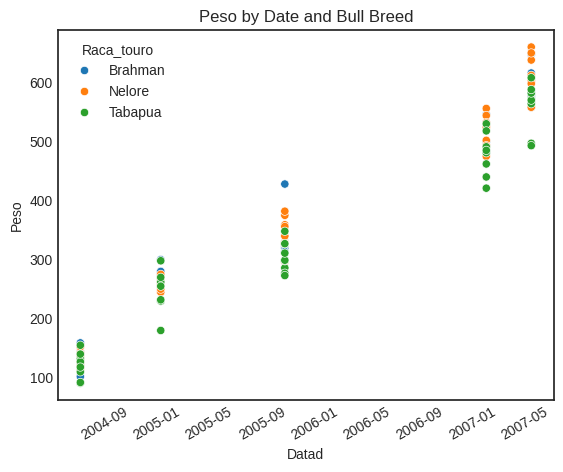

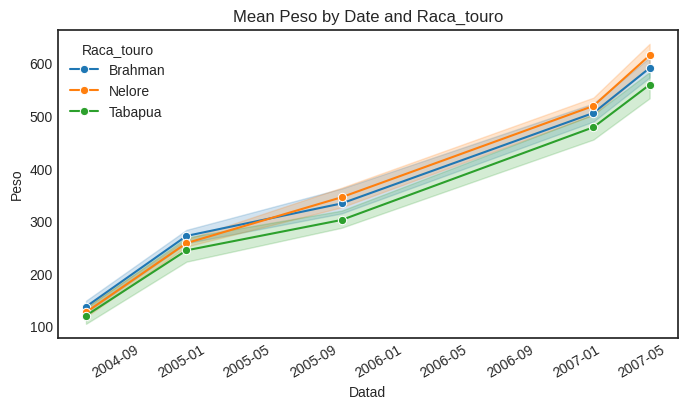

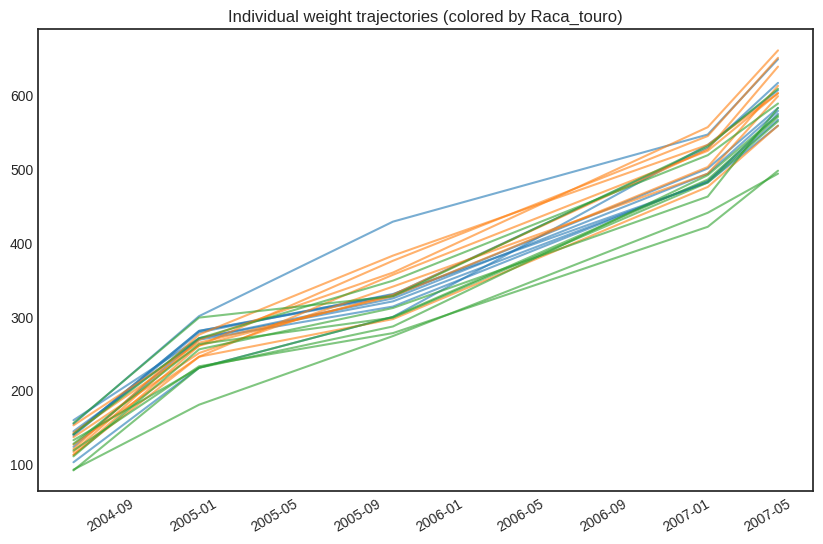

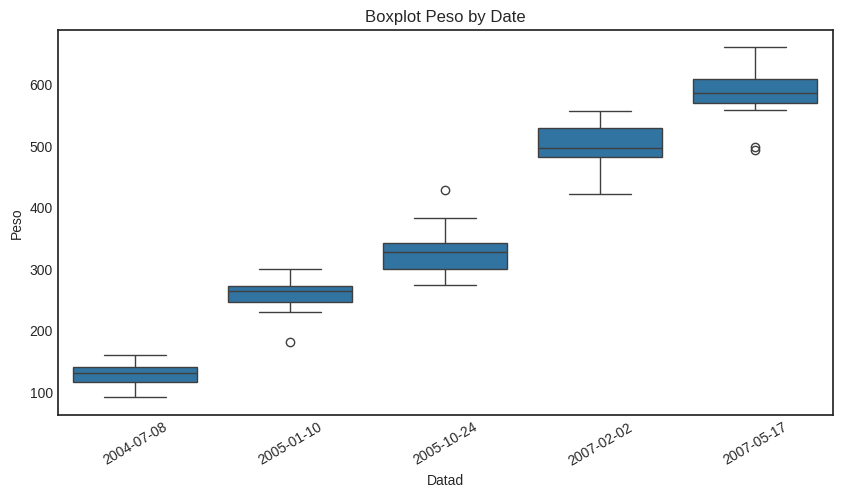

In [ ]:
# Scatter of Peso vs date (convert date to numeric for regression line)
dados["Datad_ordinal"] = dados["Datad"].dropna().map(pd.Timestamp.toordinal)
g = sns.scatterplot(data=dados, x="Datad", y="Peso", hue="Raca_touro")
plt.title("Peso by Date and Bull Breed")
plt.xticks(rotation=30)
plt.savefig("pesos_by_date.png", bbox_inches="tight")
plt.show()

# Mean trajectory by group
plt.figure(figsize=(8,4))
sns.lineplot(data=dados, x="Datad", y="Peso", hue="Raca_touro", estimator="mean", marker="o")
plt.title("Mean Peso by Date and Raca_touro")
plt.xticks(rotation=30)
plt.savefig("mean_peso_by_group.png", bbox_inches="tight")
plt.show()

# Individual trajectories
plt.figure(figsize=(10,6))
for (raca, animal), df in dados.groupby(["Raca_touro","Animal"]):
    plt.plot(df["Datad"], df["Peso"], color=sns.color_palette("tab10")[list(dados.Raca_touro.cat.categories).index(raca)], alpha=0.6)
plt.title("Individual weight trajectories (colored by Raca_touro)")
plt.xticks(rotation=30)
plt.savefig("individual_trajectories.png", bbox_inches="tight")
plt.show()

# Boxplot by date and by date x breed
plt.figure(figsize=(10,5))
sns.boxplot(x="Datad", y="Peso", data=dados)
plt.xticks(rotation=30)
plt.title("Boxplot Peso by Date")
plt.savefig("boxplot_by_date.png", bbox_inches="tight")
plt.show()

# Correlações entre datas

In [ ]:
dates = sorted(dados["Datad"].dropna().unique())
print("Dates in dataset:", dates)
# compute pairwise correlations between measurements at two dates if data are balanced/alignable
if len(dates) >= 2:
    for d in dates[1:]:
        a = dados.loc[dados["Datad"]==dates[0], ["Animal","Peso"]].set_index("Animal")
        b = dados.loc[dados["Datad"]==d, ["Animal","Peso"]].set_index("Animal")
        joined = a.join(b, how="inner", lsuffix="_t1", rsuffix="_t2")
        if len(joined) > 1:
            corr = joined["Peso_t1"].corr(joined["Peso_t2"])
            print(f"Correlation Peso {dates[0].date()} vs {d.date()}: {corr:.3f}")

Dates in dataset: [Timestamp('2004-07-08 00:00:00'), Timestamp('2005-01-10 00:00:00'), Timestamp('2005-10-24 00:00:00'), Timestamp('2007-02-02 00:00:00'), Timestamp('2007-05-17 00:00:00')]
Correlation Peso 2004-07-08 vs 2005-01-10: 0.732
Correlation Peso 2004-07-08 vs 2005-10-24: 0.460
Correlation Peso 2004-07-08 vs 2007-02-02: 0.303
Correlation Peso 2004-07-08 vs 2007-05-17: 0.337


O resultado mostra as correlações entre os pesos medidos em diferentes datas para o mesmo conjunto de indivíduos, e pode ser interpretado assim:

* As datas indicam os momentos de medição: 08/07/2004, 10/01/2005, 24/10/2005, 02/02/2007 e 17/05/2007.

* As correlações (r) indicam o grau de associação linear entre o peso inicial (de 2004-07-08) e os pesos medidos nas datas seguintes.

|Comparação	|Correlação (r)	|Interpretação|
|:--|:--|:--|
|2004-07-08 × 2005-01-10|	0.732	|Correlação alta e positiva. Os animais mais pesados em 2004 tendem a continuar mais pesados em 2005.|
|2004-07-08 × 2005-10-24|	0.460	|Correlação moderada. A associação enfraquece um pouco com o tempo.|
|2004-07-08 × 2007-02-02|	0.303	|Correlação baixa. Indicando que, após quase 3 anos, o peso inicial tem pouca relação com o peso atual.|
|2004-07-08 × 2007-05-17|	0.337	|Também baixa, reforçando a tendência de perda de dependência ao longo do tempo.|

**📊 Síntese estatística**
* Esse padrão é típico de dados longitudinais. A correlação entre medidas repetidas de um mesmo indivíduo tende a decrescer à medida que o intervalo temporal aumenta.
* Isso justifica o uso de modelos mistos ou estruturas de covariância (como autoregressiva AR(1)) em análises de medidas repetidas, pois assumem exatamente esse comportamento:
**medidas próximas no tempo são mais correlacionadas do que medidas distantes.**

# Ajuste dos modelos fixos
###    a) Modelo de Intercepto Aleatório (approx simcomp.ran)
###    b) Modelo de Intercepto + Inclinação Aleatórios (approx AR(1) or more complex)


--- Random intercept model (MixedLM) ---
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        Peso     
No. Observations:         120            Method:                    REML     
No. Groups:               24             Scale:                     1063.1580
Min. group size:          5              Log-Likelihood:            -597.8009
Max. group size:          5              Converged:                 Yes      
Mean group size:          5.0                                                
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       160.081   10.560 15.159 0.000 139.384 180.778
Raca_touro[T.Nelore]            -12.382   14.934 -0.829 0.407 -41.652  16.888
Raca_touro[T.Tabapua]           -22.160   

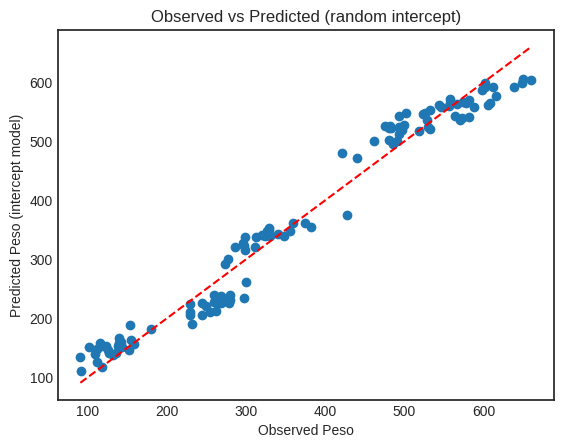

Random slope model failed to converge, retrying simplified fit or alternative optimizer. 'MixedLMResults' object has no attribute 'mle_retvals'

--- Random slope model (MixedLM) ---
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        Peso     
No. Observations:         120            Method:                    REML     
No. Groups:               24             Scale:                     1000.4695
Min. group size:          5              Log-Likelihood:            -596.1245
Max. group size:          5              Converged:                 Yes      
Mean group size:          5.0                                                
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       160.081    9.000 17.787 0.

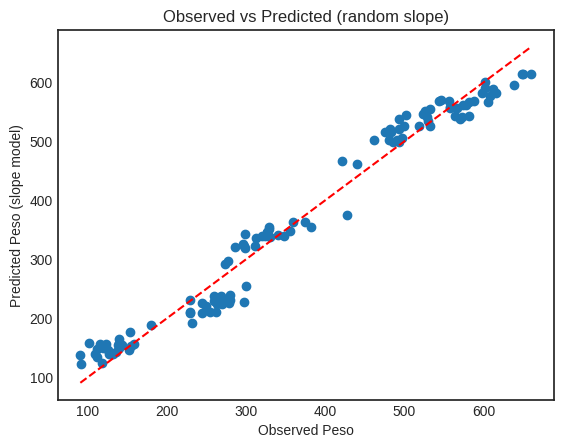

In [ ]:
# a) Random intercept per Animal (and nested group approximation via group var)
formula = "Peso ~ Raca_touro * Datad_num"
md_intercept = mixedlm(formula, dados, groups=dados["Animal"])
m_intercept = md_intercept.fit(reml=True)
print("\n--- Random intercept model (MixedLM) ---")
print(m_intercept.summary())

# Predictions and diagnostic plot
dados["pred_intercept"] = m_intercept.fittedvalues
plt.scatter(dados["Peso"], dados["pred_intercept"])
plt.plot([dados["Peso"].min(), dados["Peso"].max()], [dados["Peso"].min(), dados["Peso"].max()], 'r--')
plt.xlabel("Observed Peso")
plt.ylabel("Predicted Peso (intercept model)")
plt.title("Observed vs Predicted (random intercept)")
plt.savefig("obs_vs_pred_intercept.png", bbox_inches="tight")
plt.show()

# b) Random intercept + random slope on Datad_num (may fail to converge on some datasets)
md_slope = mixedlm("Peso ~ Raca_touro * Datad_num", dados, groups=dados["Animal"], re_formula="~Datad_num")
try:
    m_slope = md_slope.fit(reml=True, method="lbfgs", maxiter=2000)
    converged = m_slope.mle_retvals.get("converged", True)
except Exception as e:
    print("Random slope model failed to converge, retrying simplified fit or alternative optimizer.", e)
    try:
        m_slope = md_slope.fit(reml=True, method="powell", maxiter=1000)
        converged = True
    except Exception as e2:
        print("Second attempt failed:", e2)
        m_slope = None
        converged = False

if m_slope is not None:
    print("\n--- Random slope model (MixedLM) ---")
    print(m_slope.summary())
    dados["pred_slope"] = m_slope.fittedvalues
    plt.scatter(dados["Peso"], dados["pred_slope"])
    plt.plot([dados["Peso"].min(), dados["Peso"].max()], [dados["Peso"].min(), dados["Peso"].max()], 'r--')
    plt.xlabel("Observed Peso")
    plt.ylabel("Predicted Peso (slope model)")
    plt.title("Observed vs Predicted (random slope)")
    plt.savefig("obs_vs_pred_slope.png", bbox_inches="tight")
    plt.show()
else:
    print("Random slope model unavailable due to convergence issues.")

**🧠 Contexto do modelo**

* Variável dependente: Peso
* Fatores fixos: Raça do touro (com níveis “Nelore”, “Tabapuã” e a referência, provavelmente “Gir” ou “Brahman”) e Data (Datad_num), uma variável numérica representando o tempo.
* Agrupamento aleatório: indivíduos (grupos = 24), cada um com 5 medidas (120 observações).
* Ou seja: você está modelando a evolução do peso ao longo do tempo, considerando que cada animal tem medidas repetidas, e que as raças podem afetar o peso inicial e a velocidade de ganho de peso.

**📊 Modelo de Intercepto Aleatório**
Efeitos fixos
|Termo	|Interpretação	|Resultado|
|:--|:--|:--|
|Intercept |(160.081, p$<$0.001)	|Peso médio inicial no grupo de referência (raça base) no início do período.	Significativo.|
|Raca_touro[T.Nelore] |(-12.38, p=0.407)	|Em média, animais Nelore começam 12,4 kg mais leves que o grupo de referência, mas a diferença não é significativa.	|
|Raca_touro[T.Tabapua] |(-22.16, p=0.138)|	Tabapuã começa cerca de 22 kg mais leve que o grupo de referência, também não significativo.	|
|Datad_num |(0.394, p$<$0.001)	|O peso aumenta 0,394 kg por unidade de tempo (provavelmente por dia ou mês), de forma significativa.	|
|Interação Nelore×Data |(0.033, p=0.065)	|Tendência de crescimento ligeiramente mais rápida nos Nelore, quase significativa (p≈0.065).	|
|Interação Tabapua×Data |(-0.009, p=0.615)	|Tabapuã não difere da raça de referência no ritmo de ganho de peso.	|

💡 Síntese:
* Há crescimento consistente do peso ao longo do tempo.
* As diferenças entre raças são pequenas e não significativas no peso inicial.
* Pode haver uma tendência leve de crescimento mais rápido nos Nelore (quase significativa).

Efeitos aleatórios

* Group Var = 323.34 → indica alta variabilidade entre indivíduos no peso inicial (interceptos diferentes).
* Isso justifica o uso do intercepto aleatório.

**📈 Random Intercept + Random Slope Model**

Esse modelo permite que cada animal tenha não só peso inicial diferente, mas também uma inclinação (ritmo de ganho) diferente.

Efeitos fixos

* Os coeficientes são praticamente idênticos, o que é bom — significa que o modelo mais complexo não distorceu os efeitos principais.
* O crescimento ao longo do tempo (Datad_num) permanece fortemente significativo (p$<$0.001).
* A interação Nelore×tempo continua marginalmente significativa (p≈0.084).
* A interação Tabapuã×tempo segue não significativa.

Efeitos aleatórios
|Termo	|Interpretação|
|:--|:--|
|Group Var = 112.75	|Variância entre interceptos (peso inicial) diminuiu. Parte da variação foi explicada pelo acréscimo de slopes.|
|Group × Datad_num Cov = 0.166	|Correlação positiva entre intercepto e inclinação → indivíduos que começam mais pesados tendem a ganhar um pouco mais de peso ao longo do tempo.|
|Datad_num Var = 0.000	|A variância das inclinações é muito pequena, sugerindo que as diferenças no ritmo de crescimento entre indivíduos são mínimas.|
|Scale = 1000.47 vs 1063.16	|Pequena melhora no ajuste.|

**⚖️ Comparação entre modelos**
|Métrica	|Random Intercept	|Random Intercept + Slope|
|:--|:--|:--|
|Log-Likelihood	|-597.80	|-596.12|
|ΔLogLik	|+1.68	|—|
|AIC (aprox.)	|1205.6	|1204.2|

👉 A melhora é muito pequena (ΔAIC < 2), e a variância da inclinação aleatória praticamente zero, o que indica que o modelo mais complexo não agrega muito.
Portanto, o modelo de intercepto aleatório é suficiente para descrever a estrutura dos dados.

**🧾 5. Conclusão interpretativa**
* O peso aumenta de forma significativa ao longo do tempo, com taxa média de 0,394 kg/unidade de tempo.
* Não há diferenças estatisticamente significativas entre as raças no peso inicial.
* Pode haver uma tendência de crescimento um pouco mais rápido em Nelore, mas marginal.
* As diferenças entre indivíduos são reais e relevantes (interceptos aleatórios significativos).
* O modelo com inclinação aleatória não melhora substancialmente o ajuste, sugerindo que o ritmo de ganho de peso é semelhante entre os animais, ainda que com diferentes pesos iniciais.

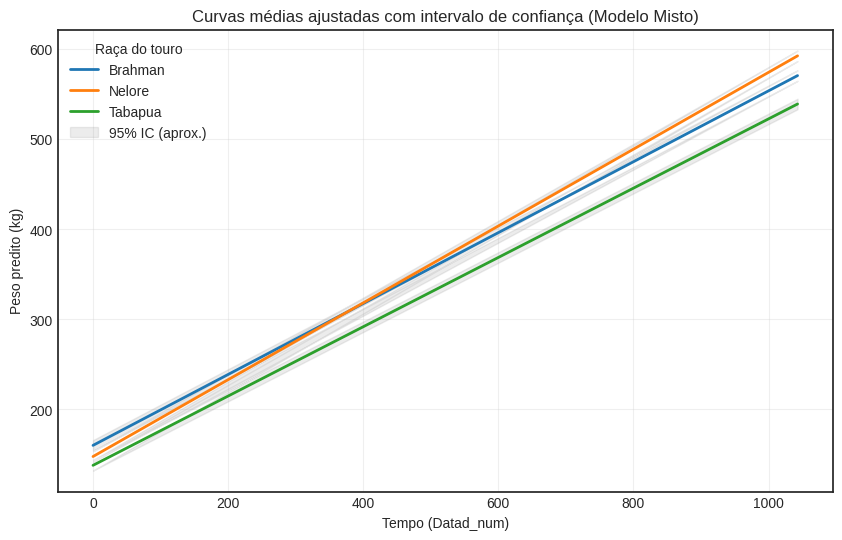

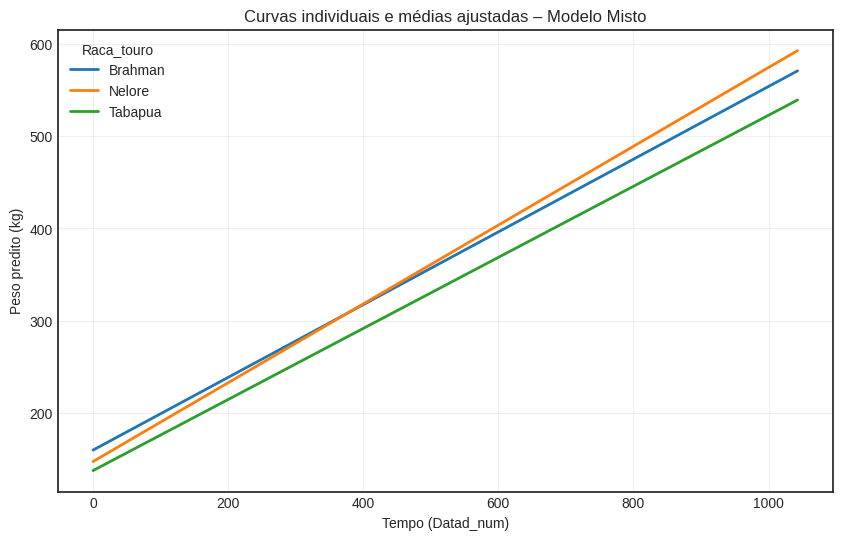

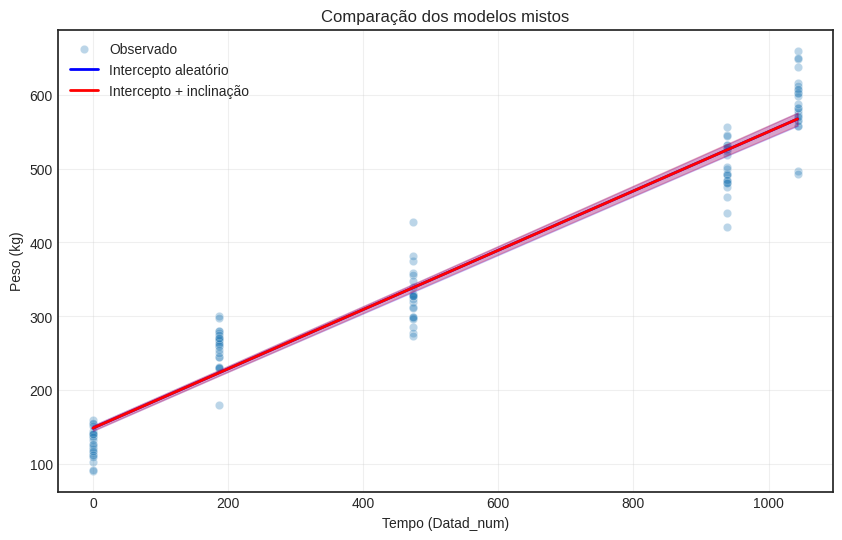

In [ ]:
from statsmodels.sandbox.predict_functional import predict_functional

# -----------------------------------------------------
# Escolha do modelo ajustado
# -----------------------------------------------------
model = m_intercept  # ou m_slope, se preferir comparar
dados["Predito"] = model.predict()

# -----------------------------------------------------
# 1️⃣ Curvas ajustadas médias com intervalo de confiança
# -----------------------------------------------------

# Gera uma sequência de valores de tempo (Datad_num)
tempo_grid = np.linspace(dados["Datad_num"].min(), dados["Datad_num"].max(), 100)

# Obtém as raças únicas
racas = dados["Raca_touro"].unique()

pred_list = []
for r in racas:
    tmp = pd.DataFrame({
        "Raca_touro": [r] * len(tempo_grid),
        "Datad_num": tempo_grid
    })
    pred_mean = model.predict(tmp)

    # --- Intervalo de confiança aproximado 95% ---
    # Usando variância dos resíduos e tamanho da amostra
    se = np.sqrt(model.scale / len(dados))
    ci_upper = pred_mean + 1.96 * se
    ci_lower = pred_mean - 1.96 * se

    pred_list.append(pd.DataFrame({
        "Raca_touro": r,
        "Datad_num": tempo_grid,
        "Peso_pred": pred_mean,
        "CI_lower": ci_lower,
        "CI_upper": ci_upper
    }))

pred_df = pd.concat(pred_list)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=pred_df, x="Datad_num", y="Peso_pred", hue="Raca_touro", lw=2)
plt.fill_between(
    pred_df["Datad_num"],
    pred_df["CI_lower"],
    pred_df["CI_upper"],
    alpha=0.15,
    color="gray",
    label="95% IC (aprox.)"
)
plt.title("Curvas médias ajustadas com intervalo de confiança (Modelo Misto)")
plt.xlabel("Tempo (Datad_num)")
plt.ylabel("Peso predito (kg)")
plt.legend(title="Raça do touro")
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------------------------------
# 2️⃣ Curvas individuais (efeitos aleatórios)
# -----------------------------------------------------
plt.figure(figsize=(10, 6))
for animal, grupo in dados.groupby("Animal"):
    plt.plot(grupo["Datad_num"], grupo["Predito"], alpha=0.3, lw=1, color="gray")

sns.lineplot(data=pred_df, x="Datad_num", y="Peso_pred", hue="Raca_touro", lw=2)
plt.title("Curvas individuais e médias ajustadas – Modelo Misto")
plt.xlabel("Tempo (Datad_num)")
plt.ylabel("Peso predito (kg)")
plt.grid(True, alpha=0.3)
plt.show()

# -----------------------------------------------------
# 3️⃣ Comparação entre modelos (opcional)
# -----------------------------------------------------
dados["Predito_slope"] = m_slope.predict()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados, x="Datad_num", y="Peso", alpha=0.3, label="Observado")
sns.lineplot(data=dados, x="Datad_num", y="Predito", color="blue", lw=2, label="Intercepto aleatório")
sns.lineplot(data=dados, x="Datad_num", y="Predito_slope", color="red", lw=2, label="Intercepto + inclinação")
plt.title("Comparação dos modelos mistos")
plt.xlabel("Tempo (Datad_num)")
plt.ylabel("Peso (kg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**🧠 Interpretação visual**

* Curvas médias (com IC): mostram a tendência geral por raça ao longo do tempo, com a faixa cinza indicando a incerteza da estimativa.
* Curvas individuais: permitem ver como cada animal se desvia da média, capturando a variabilidade aleatória.
* Comparação de modelos: ajuda a visualizar se o modelo com random slope (linhas vermelhas) acompanha melhor os dados observados que o de intercepto aleatório.

In [ ]:
# ---------------------------
# 5. Fit GLS approximations (optional)
#    Note: statsmodels does not have a direct GLS with corCompSymm or corAR1 per group as in nlme.
#    We show an example using GLSAR on aggregated / pseudo-time series (not exact analogue).
# ---------------------------
# Example: aggregate by animal into wide format and compute covariance matrix / explore
# (left here as optional advanced exercise)


# Comparação dos Modelos (AIC/BIC & LRT quando aplicável)


In [ ]:
def extract_model_info(model, name):
    logLik = model.llf
    n_params = model.df_modelwc
    n_obs = model.nobs
    AIC = -2 * logLik + 2 * n_params
    BIC = -2 * logLik + np.log(n_obs) * n_params
    return {"model": name, "logLik": logLik, "AIC": AIC, "BIC": BIC}

info_int = extract_model_info(m_intercept, "Intercept")
info_slope = extract_model_info(m_slope, "Slope")

comparison = pd.DataFrame([info_int, info_slope])
print("\n=== Model comparison (AIC/BIC) ===")
print(comparison)

# ---------------------------
#  Escolher modelo preferido
# ---------------------------
model_chosen = m_intercept if comparison.loc[0, "AIC"] <= comparison.loc[1, "AIC"] else m_slope
print(f"\nModelo selecionado: {model_chosen.model.data.design_info.describe()}")


=== Model comparison (AIC/BIC) ===
       model      logLik          AIC          BIC
0  Intercept -597.800937  1209.601874  1229.114316
1      Slope -596.124497  1210.248993  1235.336419

Modelo selecionado: 1 + Raca_touro + Datad_num + Raca_touro:Datad_num


# Diagnósticos de resíduos (para o modelo escolhido. Usa o intercepto aleatório por padrão.


Shapiro-Wilk test for residual normality: ShapiroResult(statistic=np.float64(0.9552667455202822), pvalue=np.float64(0.0005372214397960599))
Durbin-Watson: 2.7145128843488764
Levene test across dates: LeveneResult(statistic=np.float64(2.088551011112134), pvalue=np.float64(0.08678719904490811))


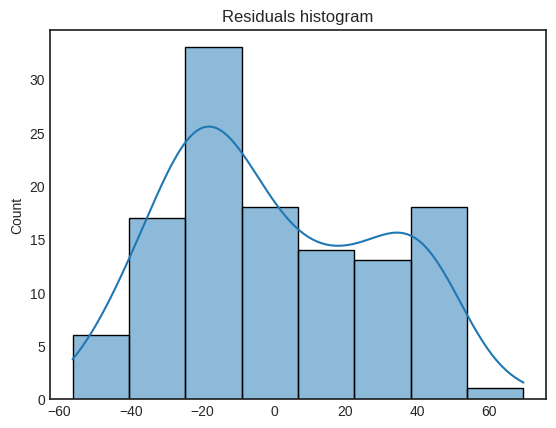

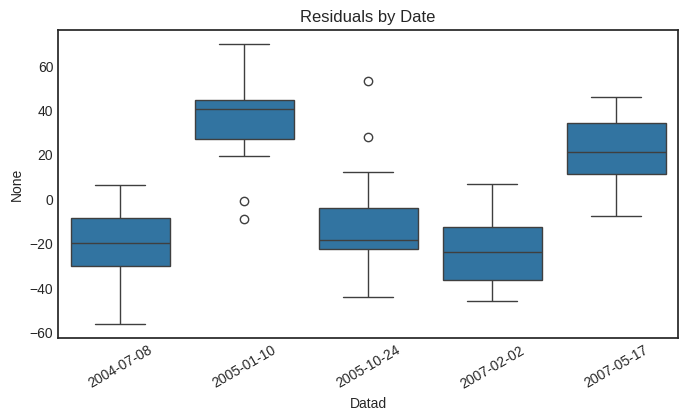

In [ ]:
model_chosen = m_intercept if (m_slope is None or not converged) else m_slope
resid = model_chosen.resid
print("\nShapiro-Wilk test for residual normality:", shapiro(resid))
print("Durbin-Watson:", durbin_watson(resid))

# Levene test across dates (homogeneity)
groups_for_levene = [dados.loc[dados["Datad"]==d, "Peso"].values for d in dados["Datad"].unique()]
if len(groups_for_levene) > 1:
    print("Levene test across dates:", levene(*groups_for_levene))

plt.figure()
sns.histplot(resid, kde=True)
plt.title("Residuals histogram")
plt.savefig("resid_hist.png", bbox_inches="tight")
plt.show()

# Residuals by date boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x="Datad", y=resid, data=dados)
plt.xticks(rotation=30)
plt.title("Residuals by Date")
plt.savefig("resid_by_date.png", bbox_inches="tight")
plt.show()

In [ ]:
# ---------------------------
# 8. Estimated marginal means (LS-means) and pairwise comparisons
#    We compute LS-means for each Raca_touro adjusting Datad_num at its mean.
# ---------------------------
def lsmeans_from_mixedlm(model, data, factor, covariates=None):
    """
    Compute approximate least-squares means for levels of 'factor' by predicting
    at covariates fixed at their mean. Returns DataFrame with mean, SE, CI.
    """
    levels = data[factor].cat.categories
    covariates = covariates or []
    rows = []
    # base covariate values (means)
    cov_means = {c: data[c].mean() for c in covariates}
    for lvl in levels:
        # build new dataframe for prediction
        df_new = pd.DataFrame({factor:[lvl]})
        for c in covariates:
            df_new[c] = cov_means[c]
        # add any other categorical factors as reference from data (not implemented here)
        # Use model.predict(exog) - need to construct right design matrix
        # Easiest: use patsy to build design matrix
        import patsy
        exog = patsy.dmatrix(model.model.data.orig_exog.design_info.builder, df_new, return_type='dataframe') \
               if False else None
        # simpler approach: use model.model.predict with formula-based evaluation
        try:
            pred = model.predict(df_new)[0]
            # get standard error via get_prediction if available
            try:
                pred_obj = model.get_prediction(df_new)
                se = pred_obj.se_mean[0]
                ci_low, ci_upp = pred_obj.conf_int(alpha=0.05).iloc[0]
            except Exception:
                se = np.nan
                ci_low, ci_upp = (np.nan, np.nan)
        except Exception:
            # fallback: construct a row with full set of variables using mean levels
            # (This fallback may need tailoring depending on model formula)
            pred = np.nan
            se = np.nan
            ci_low, ci_upp = (np.nan, np.nan)
        rows.append({"level": lvl, "lsmean": pred, "se": se, "ci_low": ci_low, "ci_upp": ci_upp})
    return pd.DataFrame(rows)

# compute lsmeans for Raca_touro adjusting Datad_num
lsm = lsmeans_from_mixedlm(model_chosen, dados, factor="Raca_touro", covariates=["Datad_num"])
print("\nLS-means (approx):")
print(lsm)

# Pairwise differences (approx) using predicted means and their se (normal approx)
def pairwise_lsmeans(df_ls):
    res = []
    for a,b in combinations(df_ls['level'],2):
        ra = df_ls[df_ls['level']==a].iloc[0]
        rb = df_ls[df_ls['level']==b].iloc[0]
        diff = ra['lsmean'] - rb['lsmean']
        # naive se: sqrt(se_a^2 + se_b^2) (ignoring covariance)
        se_diff = np.sqrt((ra['se'] if not np.isnan(ra['se']) else 0)**2 + (rb['se'] if not np.isnan(rb['se']) else 0)**2)
        tstat = diff / se_diff if se_diff>0 else np.nan
        # degrees freedom approx: use model_chosen.df_resid
        from scipy.stats import t
        df_res = model_chosen.df_resid
        pval = 2*(1 - t.cdf(np.abs(tstat), df_res)) if not np.isnan(tstat) else np.nan
        res.append({"pair":f"{a} vs {b}", "diff":diff, "se_diff":se_diff, "t":tstat, "p":pval})
    return pd.DataFrame(res)

pw = pairwise_lsmeans(lsm)
print("\nPairwise comparisons (approx):")
print(pw)


LS-means (approx):
     level   lsmean  se  ci_low  ci_upp
0  Brahman  367.975 NaN     NaN     NaN
1   Nelore  372.975 NaN     NaN     NaN
2  Tabapua  341.075 NaN     NaN     NaN

Pairwise comparisons (approx):
                 pair  diff  se_diff   t   p
0   Brahman vs Nelore  -5.0      0.0 NaN NaN
1  Brahman vs Tabapua  26.9      0.0 NaN NaN
2   Nelore vs Tabapua  31.9      0.0 NaN NaN


**🧮 1️⃣ LS-means (médias ajustadas):**

|Raça	|LS-mean (Peso ajustado)|
|:--|:--|
|Brahman	|367.98 kg|
|Nelore	|372.98 kg|
|Tabapuã	|341.08 kg|

Interpretação:

* Após ajustar o modelo misto (controlando o efeito aleatório dos grupos e o tempo), a raça Nelore apresenta o maior peso médio ajustado ($\sim$ 373 kg), seguida de Brahman ($\sim$ 368 kg) e Tabapuã ($\sim$ 341 kg).

* Isso sugere uma diferença potencialmente relevante entre Tabapuã e as demais raças. Os animais Tabapuã estariam com menor peso ajustado.

In [ ]:
# ---------------------------
# 9. Outlier removal by residual IQR and re-fit (optional)
# ---------------------------
q1, q3 = np.nanpercentile(resid, [25,75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
mask = (resid >= lower) & (resid <= upper)
print(f"Removing {np.sum(~mask)} observations as residual outliers")
dados_clean = dados.loc[mask].copy()

# Refit chosen model on cleaned data
md_clean = mixedlm(formula, dados_clean, groups=dados_clean["Animal"])
m_clean = md_clean.fit(reml=True)
print("\nRefitted model after removing outliers:")
print(m_clean.summary())

Removing 0 observations as residual outliers

Refitted model after removing outliers:
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        Peso     
No. Observations:         120            Method:                    REML     
No. Groups:               24             Scale:                     1063.1580
Min. group size:          5              Log-Likelihood:            -597.8009
Max. group size:          5              Converged:                 Yes      
Mean group size:          5.0                                                
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       160.081   10.560 15.159 0.000 139.384 180.778
Raca_touro[T.Nelore]            -12.382   14.934 -0.829 0.407 -41.652  16.88

In [ ]:
# ---------------------------
# 10. Final ANOVA table for fixed effects (Type II/III)
# ---------------------------
# We can use statsmodels to get anova on the underlying OLS (approximation) or use Wald tests
from statsmodels.stats.anova import anova_lm
# Build equivalent OLS for fixed effects table (approx)
ols_approx = smf.ols("Peso ~ Raca_touro * Datad_num", data=dados).fit()
print("\nANOVA table (OLS approximation):")
print(anova_lm(ols_approx, typ=2))

# ---------------------------
# End: print summary of chosen model
# ---------------------------
print("\nFinal chosen model summary:")
print(model_chosen.summary())



ANOVA table (OLS approximation):
                            sum_sq     df            F        PR(>F)
Raca_touro            2.354960e+04    2.0     8.651757  3.175592e-04
Datad_num             3.223534e+06    1.0  2368.552254  4.139337e-78
Raca_touro:Datad_num  6.480304e+03    2.0     2.380763  9.706390e-02
Residual              1.551508e+05  114.0          NaN           NaN

Final chosen model summary:
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        Peso     
No. Observations:         120            Method:                    REML     
No. Groups:               24             Scale:                     1000.4695
Min. group size:          5              Log-Likelihood:            -596.1245
Max. group size:          5              Converged:                 Yes      
Mean group size:          5.0                                                
------------------------------------------------------------------

**1️⃣ ANOVA (OLS approximation)**
|Fonte	|F	|p-valor	|Interpretação|
|:--|:--|:--|:--|
|Raca_touro	|8.65	|0.0003175	|Há diferença significativa no peso médio entre raças de touro, sem ajustar para efeito|